# Plotting NOAA VIIRS DNB Using Python

The 500m Day Night Band (DNB) from the Visible Infrared Imaging Radiometer Suite of Suomi NPP/NOAA-20 can be downloaded by searching "VIIRS Gridded" on https://search.earthdata.nasa.gov/. 

You will be needing an account to proceed.

Also, please read the Black Marble User guide (https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/viirs/VIIRS_Black_Marble_UG_v1.1_July_2020.pdf) to save yourself from some headaches. 

#### Imports and Paths

For this exercise we will need to install the following:

1. **h5py** (https://www.h5py.org/) to read the HD5 file
2. **cartopy** (https://scitools.org.uk/cartopy/docs/latest/) to plot in a fancy map

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cartopy.crs as ccrs
import os

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

VIIRS_path = 'D:/Data/VIIRS'
viirs_path = os.path.join(VIIRS_path,
                          'VNP46A1.A2021081.h30v07.001.2021082071138.h5')


#### Reading the h5 dataset

In [2]:
viirs_ds = h5py.File(viirs_path, 'r')

Check the available keys

In [3]:
viirs_ds.keys()

[u'HDFEOS', u'HDFEOS INFORMATION']

In this case we will be needing the HDFEOS group. Let's take a look what's inside.

In [4]:
viirs_ds['HDFEOS'].keys()

[u'ADDITIONAL', u'GRIDS']

Need to dig deeper

In [5]:
viirs_ds['HDFEOS/GRIDS'].keys()

[u'VNP_Grid_DNB']

*Deeper....*

In [6]:
viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].keys()

[u'Data Fields']

*Much deeper....*

In [7]:
viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields'].keys()

[u'BrightnessTemperature_M12',
 u'BrightnessTemperature_M13',
 u'BrightnessTemperature_M15',
 u'BrightnessTemperature_M16',
 u'DNB_At_Sensor_Radiance_500m',
 u'Glint_Angle',
 u'Granule',
 u'Lunar_Azimuth',
 u'Lunar_Zenith',
 u'Moon_Illumination_Fraction',
 u'Moon_Phase_Angle',
 u'QF_Cloud_Mask',
 u'QF_DNB',
 u'QF_VIIRS_M10',
 u'QF_VIIRS_M11',
 u'QF_VIIRS_M12',
 u'QF_VIIRS_M13',
 u'QF_VIIRS_M15',
 u'QF_VIIRS_M16',
 u'Radiance_M10',
 u'Radiance_M11',
 u'Sensor_Azimuth',
 u'Sensor_Zenith',
 u'Solar_Azimuth',
 u'Solar_Zenith',
 u'UTC_Time']

We will be needing the DNB_At_Sensor_Radiance_500m (or Day Night Band). Assign that to a variable for now.

In [8]:
dnb = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields/DNB_At_Sensor_Radiance_500m']

Let's check out how this looks. For this case I used vmax = 100 because it looks nice. But if you will be needing further processing I suggest you take a look at the manual to understand the units of the DNB pixels.

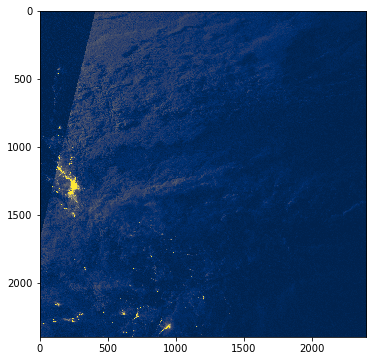

In [9]:
cmap = plt.get_cmap('cividis')

fig =  plt.figure(figsize=(6,6))
ax = plt.axes()

ax.imshow(dnb, cmap = cmap, vmin = 0, vmax = 100)
plt.show()

It looks interesting for now, but we will want this on a map. So we'll need the coordinate metadata.

Let's go back and take a look at the attributes.

In [10]:
list(viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs)

[u'InputPointer_CM',
 u'InputPointer_L2G_DNB',
 u'InputPointer_L2G_Ang',
 u'InputPointer_L2G_PNTR',
 u'InputPointer_DNB',
 u'InputPointer_Mod',
 u'useCM',
 u'CMfill',
 u'RangeBeginningDate',
 u'RangeBeginningTime',
 u'RangeEndingDate',
 u'RangeEndingTime',
 u'NorthBoundingCoord',
 u'SouthBoundingCoord',
 u'EastBoundingCoord',
 u'WestBoundingCoord',
 u'TileID',
 u'TileMode',
 u'HorizontalTileNumber',
 u'VerticalTileNumber',
 u'NumberofInputGranules',
 u'PGE_Name',
 u'PGEVersion',
 u'SatelliteInstrument',
 u'ReprocessingPlanned',
 u'ReprocessingActual',
 u'ProcessingEnvironment',
 u'ScienceQualityFlagExplanation']

We are interested in the XXXBoundingCoord so let's extract them and save as variables.

In [11]:
lat_max = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs['NorthBoundingCoord']
lat_min = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs['SouthBoundingCoord']
lon_max = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs['EastBoundingCoord']
lon_min = viirs_ds['HDFEOS/GRIDS/VNP_Grid_DNB'].attrs['WestBoundingCoord']

In [12]:
print('Latitudes: '+str(lat_min[0]) +', '+ str(lat_max[0]))
print('Longitudes: '+str(lon_min[0]) +', '+ str(lon_max[0]))

Latitudes: 10.0, 20.0
Longitudes: 120.0, 130.0


Now let's create our meshgrid using the shape of our dnb array.

In [13]:
lats = np.linspace(lat_max, lat_min, dnb.shape[1])
lons = np.linspace(lon_min, lon_max, dnb.shape[0])
x, y = np.meshgrid(lons, lats)

Now we can plot. Notice how instead of image coordinates (pixels), we now have lons and lats for the x and y axes.

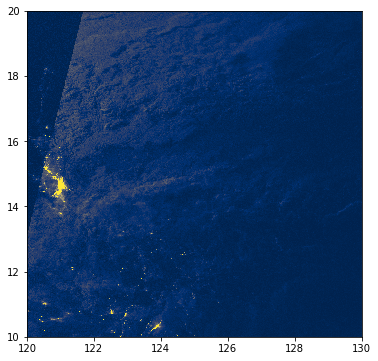

In [14]:
cmap = plt.get_cmap('cividis')

fig =  plt.figure(figsize=(6,6))
ax = plt.axes()

ax.pcolormesh(x, y, dnb, cmap = cmap, vmin = 0, vmax = 100)
plt.show()

If you want to overlay a map on this plot it's now time to call on cartopy

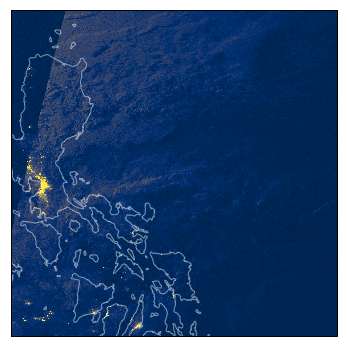

In [15]:
cmap = plt.get_cmap('cividis')
crs = ccrs.PlateCarree()

fig =  plt.figure(figsize=(6,6))
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', color='white',alpha=0.5)
ax.pcolormesh(x, y, dnb, cmap = cmap, vmin = 0, vmax = 100)

plt.xlim((lon_min,lon_max))
plt.ylim((lat_min,lat_max))

plt.show()

If you want to get fancy and all that you can add grids and labels like so.

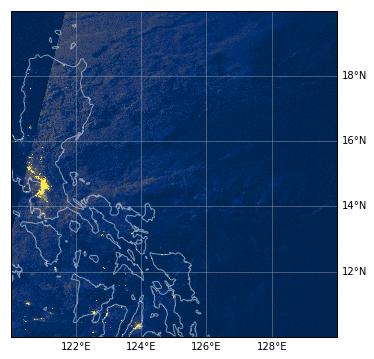

In [16]:
cmap = plt.get_cmap('cividis')
crs = ccrs.PlateCarree()

fig =  plt.figure(figsize=(6,6))
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', color='white',alpha=0.5)
ax.pcolormesh(x, y, dnb, cmap = cmap, vmin = 0, vmax = 100)

plt.xlim()


gl = ax.gridlines(crs=crs, draw_labels=True, alpha=0.5)
gl.xlabels_top = None
gl.ylabels_left = None
xgrid = np.arange(lon_min-2, lon_max+2, 2.)
ygrid = np.arange(lat_min-2, lat_max+2, 2.)
gl.xlocator = mticker.FixedLocator(xgrid.tolist())
gl.ylocator = mticker.FixedLocator(ygrid.tolist())
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

plt.xlim((lon_min,lon_max))
plt.ylim((lat_min,lat_max))

plt.show()